In [ ]:
#required library installed
!pip install evaluate swifter lime datasets

In [ ]:
#importing inbuilt package from library
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from datasets import Dataset
import re
import nltk
from nltk.corpus import stopwords
import swifter
import pickle
from lime.lime_text import LimeTextExplainer
import evaluate
import random

In [ ]:
# Load and preprocess data
user_data = pd.read_csv("/content/sample_data/Training.csv")
user_data = user_data.dropna(subset=['tweets', 'status'])
user_data['tweets'] = user_data['tweets'].apply(lambda x: x if isinstance(x, str) else '')
user_data['tweets'] = user_data['tweets'].apply(lambda x: x.split(';'))
user_data['tweets']

,tweets
0,[the real reason why you be sad you be attach ...
1,[i be tire go to sleep then no you do not unde...
2,[i wish someone be afraid to lose me i be alwa...
3,[do you ever feel ok but your sad at the same ...
4,[i need someone who will understand how unstab...
...,...
511,[i cannot be the only one write lester holt fa...
512,[when i be a kid watch the carol burnett show ...
513,[my new credit card give me 2 cash back on 102...
514,[a detail lose in the story of jesus how frequ...


In [ ]:
user_data.shape

(516, 3)

In [ ]:
#check for null value
user_data.isnull().sum()

,0
user_id,0
tweets,0
status,0


In [ ]:
#classwise tuple count
user_data['status'].value_counts()

,count
status,
Normal,311
Depression,205


In [ ]:
#class balancing
dipressed=user_data.head(205)
normal=user_data.tail(205)
user_data=pd.concat([dipressed,normal])
user_data['status'].value_counts()

,count
status,
Depression,205
Normal,205


In [ ]:
# Label encoding
label_encoder = LabelEncoder()
user_data['label'] = label_encoder.fit_transform(user_data['status'])

# Split data into train, validation, and test (user-level)
train_idx, test_idx = train_test_split(range(len(user_data)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)
train_users = user_data.iloc[train_idx].reset_index(drop=True)
val_users = user_data.iloc[val_idx].reset_index(drop=True)
test_users = user_data.iloc[test_idx].reset_index(drop=True)

In [ ]:
# Load BERT tokenizer and model for embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to generate tweet embeddings with batch processing
def get_tweet_embeddings(tweets, max_length=128, batch_size=16):
    embeddings = []
    for i in range(0, len(tweets), batch_size):
        batch_tweets = tweets[i:i+batch_size]
        inputs = tokenizer(batch_tweets, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(cls_embeddings)
    return np.array(embeddings)

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Precompile regex patterns
punct_pattern = re.compile(r'[^\w\s]')
num_pattern = re.compile(r'\d+')

# Cleaning function
def clean_statement(tweet):
    # Check if tweet is a NumPy array and convert it to a string if needed
    if isinstance(tweet, np.ndarray):
        tweet = ' '.join(tweet)
    if pd.isna(tweet) or not isinstance(tweet, str):
        return ''
    tweet = tweet.lower()
    tweet = punct_pattern.sub(' ', tweet)
    tweet = num_pattern.sub('', tweet)
    words = tweet.split()
    words = [word for word in words if word not in stop_words or word in {'not', 'never'}]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Generate user-level embeddings (mean pooling)
def get_user_embedding(tweets):
    cleaned_tweets = [clean_statement(tweet) for tweet in tweets if clean_statement(tweet)]
    if not cleaned_tweets:
        print("Warning: No valid tweets for user.")
        return np.zeros(768)
    tweet_embeddings = get_tweet_embeddings(cleaned_tweets)
    return np.mean(tweet_embeddings, axis=0)

In [ ]:
# Prepare training, validation, and test data
train_embeddings = np.array([get_user_embedding(tweets) for tweets in train_users['tweets']])
val_embeddings = np.array([get_user_embedding(tweets) for tweets in val_users['tweets']])
test_embeddings = np.array([get_user_embedding(tweets) for tweets in test_users['tweets']])
train_labels = train_users['label'].values
val_labels = val_users['label'].values
test_labels = test_users['label'].values
# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [ ]:
# Define classifier for user embeddings
class UserClassifier(nn.Module):
    def __init__(self, input_dim=768, num_classes=2):
        super(UserClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x)


In [ ]:
# Initialize classifier
classifier = UserClassifier(num_classes=len(label_encoder.classes_)).to(device)

# Training setup
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Convert data to tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32).to(device)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)


In [ ]:
# Training loop with early stopping
num_epochs = 20
batch_size = 32
best_val_loss = float('inf')
patience = 3
counter = 0
train_losses = []
val_losses = []

classifier.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for i in range(0, len(train_embeddings_tensor), batch_size):
        batch_embeddings = train_embeddings_tensor[i:i+batch_size]
        batch_labels = train_labels_tensor[i:i+batch_size]
        optimizer.zero_grad()
        outputs = classifier(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= (len(train_embeddings_tensor) // batch_size + 1)
    train_losses.append(epoch_train_loss)

    # Validation
    classifier.eval()
    with torch.no_grad():
        val_outputs = classifier(val_embeddings_tensor)
        val_loss = criterion(val_outputs, val_labels_tensor).item()
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(classifier.state_dict(), "best_user_classifier.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break
classifier.load_state_dict(torch.load("best_user_classifier.pt"))

Epoch 1/20, Train Loss: 0.6768, Val Loss: 0.6611
Epoch 2/20, Train Loss: 0.6703, Val Loss: 0.6547
Epoch 3/20, Train Loss: 0.6566, Val Loss: 0.6463
Epoch 4/20, Train Loss: 0.6443, Val Loss: 0.6349
Epoch 5/20, Train Loss: 0.6322, Val Loss: 0.6216
Epoch 6/20, Train Loss: 0.6203, Val Loss: 0.6080
Epoch 7/20, Train Loss: 0.6085, Val Loss: 0.5949
Epoch 8/20, Train Loss: 0.5971, Val Loss: 0.5825
Epoch 9/20, Train Loss: 0.5860, Val Loss: 0.5708
Epoch 10/20, Train Loss: 0.5752, Val Loss: 0.5595
Epoch 11/20, Train Loss: 0.5648, Val Loss: 0.5485
Epoch 12/20, Train Loss: 0.5546, Val Loss: 0.5377
Epoch 13/20, Train Loss: 0.5448, Val Loss: 0.5272
Epoch 14/20, Train Loss: 0.5352, Val Loss: 0.5170
Epoch 15/20, Train Loss: 0.5258, Val Loss: 0.5071
Epoch 16/20, Train Loss: 0.5167, Val Loss: 0.4975
Epoch 17/20, Train Loss: 0.5079, Val Loss: 0.4881
Epoch 18/20, Train Loss: 0.4993, Val Loss: 0.4790
Epoch 19/20, Train Loss: 0.4909, Val Loss: 0.4701
Epoch 20/20, Train Loss: 0.4828, Val Loss: 0.4615


<All keys matched successfully>

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.close()

In [ ]:
# Evaluation
classifier.eval()
with torch.no_grad():
    test_outputs = classifier(test_embeddings_tensor)
    predicted_labels = torch.argmax(test_outputs, dim=1).cpu().numpy()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

  Depression       0.98      1.00      0.99        45
      Normal       1.00      0.97      0.99        37

    accuracy                           0.99        82
   macro avg       0.99      0.99      0.99        82
weighted avg       0.99      0.99      0.99        82



In [ ]:
# Confusion Matrix plot
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

In [ ]:
# Save model, tokenizer, and label encoder
torch.save(classifier.state_dict(), "user_classifier.pt")
tokenizer.save_pretrained("saved_mental_status_bert_embeddings")
pickle.dump(label_encoder, open('label_encoder_embeddings.pkl', 'wb'))


In [ ]:
# Detection function for new users
def detect_depression_user(tweets):
    cleaned_tweets = [clean_statement(tweet) for tweet in tweets]
    user_embedding = get_user_embedding(cleaned_tweets)
    user_embedding_tensor = torch.tensor(user_embedding, dtype=torch.float32).unsqueeze(0).to(device)
    classifier.eval()
    with torch.no_grad():
        output = classifier(user_embedding_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

In [ ]:
# LIME Explanation for user-level prediction
def predict_proba_user(tweets):
    cleaned_tweets = [clean_statement(tweet) for tweet in tweets]
    user_embedding = get_user_embedding(cleaned_tweets)
    user_embedding_tensor = torch.tensor(user_embedding, dtype=torch.float32).unsqueeze(0).to(device)
    classifier.eval()
    with torch.no_grad():
        output = classifier(user_embedding_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()
    return probs

In [ ]:
import csv

def organize_user_tweets(csv_file_path):
    user_data = []

    # Read the CSV file
    with open("/content/sample_data/user_tweets.csv", 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)


        for row in reader:
            username = row['username']
            tweets = []
            for key in row:
                if key.startswith('tweets/'):
                    tweet = row[key]
                    # Only add non-empty tweets
                    if tweet:
                        tweet=clean_statement(tweet)
                        tweets.append(tweet)

            user_data.append(tweets)

    return user_data


csv_file_path = 'user_tweets.csv'
user_data = organize_user_tweets(csv_file_path)


In [ ]:
# Test detection system
print("Testing Detection System:")
for user_tweets in user_data:

    predicted_class = detect_depression_user(user_tweets)
    print(f"User Tweets: {user_tweets}")
    print(f"Predicted class: {predicted_class}\n")

Testing Detection System:
User Tweets: ['waiting someone save everyone runs away waiting someone change one ever comes breaking walls cage nothing ever falls place waiting end take blinded sun', 'much hated eating disorder treatment programme back genuinely enjoyed spending time fellow patients many hours group therapy together sense camaraderie experienced anywhere else', 'tired day long magically not tired go bed night seem fair', 'feel little sad hopeless ngl keep responsibilities wish could give tired adult', 'walking lot usual week trying best get exercise good still gym getting steps every day good start', 'worst feeling ever begging someone something seeing willingly others', 'life destroying b p cycles past rather die repeat', 'going old pictures lowest weight say really miss thin', 'wanted study psychology potential patient', 'asking bare minimum still not getting anything return exhausting', 'telling someone genuinely struggling whatever reason get otherwise therapeutic setti

In [ ]:
# LIME Explanation (tweet-level)
explainer = LimeTextExplainer(class_names=label_encoder.classes_)
print("LIME Explanations (Tweet-Level Contributions):")
for user_tweets in user_data:
    predicted_class = detect_depression_user(user_tweets)
    print(f"User Tweets: {user_tweets}")
    print(f"Predicted class: {predicted_class}")
    tweet_contributions = []
    for i, tweet in enumerate(user_tweets):
        cleaned_tweet = clean_statement(tweet)
        perturbed_tweets = user_tweets[:i] + user_tweets[i+1:]
        original_probs = predict_proba_user(user_tweets)[0]
        perturbed_probs = predict_proba_user(perturbed_tweets)[0] if perturbed_tweets else np.array([0.5, 0.5])
        contribution = original_probs - perturbed_probs
        tweet_contributions.append((tweet, contribution[label_encoder.transform([predicted_class])[0]]))
    tweet_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    print("Tweet Contributions to Prediction:")
    for tweet, contrib in tweet_contributions:
        print(f"Tweet: {tweet}, Contribution: {contrib:.3f}")
    print("\n")

LIME Explanations (Tweet-Level Contributions):
User Tweets: ['waiting someone save everyone runs away waiting someone change one ever comes breaking walls cage nothing ever falls place waiting end take blinded sun', 'much hated eating disorder treatment programme back genuinely enjoyed spending time fellow patients many hours group therapy together sense camaraderie experienced anywhere else', 'tired day long magically not tired go bed night seem fair', 'feel little sad hopeless ngl keep responsibilities wish could give tired adult', 'walking lot usual week trying best get exercise good still gym getting steps every day good start', 'worst feeling ever begging someone something seeing willingly others', 'life destroying b p cycles past rather die repeat', 'going old pictures lowest weight say really miss thin', 'wanted study psychology potential patient', 'asking bare minimum still not getting anything return exhausting', 'telling someone genuinely struggling whatever reason get otherw

LIME Explanations (Tweet-Level Contributions):
User  Tweets: ['waiting someone save everyone runs away waiting someone change one ever comes breaking walls cage nothing ever falls place waiting end take blinded sun', 'much hated eating disorder treatment programme back genuinely enjoyed spending time fellow patients many hours group therapy together sense camaraderie experienced anywhere else', 'tired day long magically not tired go bed night seem fair', 'feel little sad hopeless ngl keep responsibilities wish could give tired adult', 'walking lot usual week trying best get exercise good still gym getting steps every day good start', 'worst feeling ever begging someone something seeing willingly others', 'life destroying b p cycles past rather die repeat', 'going old pictures lowest weight say really miss thin', 'wanted study psychology potential patient', 'asking bare minimum still not getting anything return exhausting', 'telling someone genuinely struggling whatever reason get other

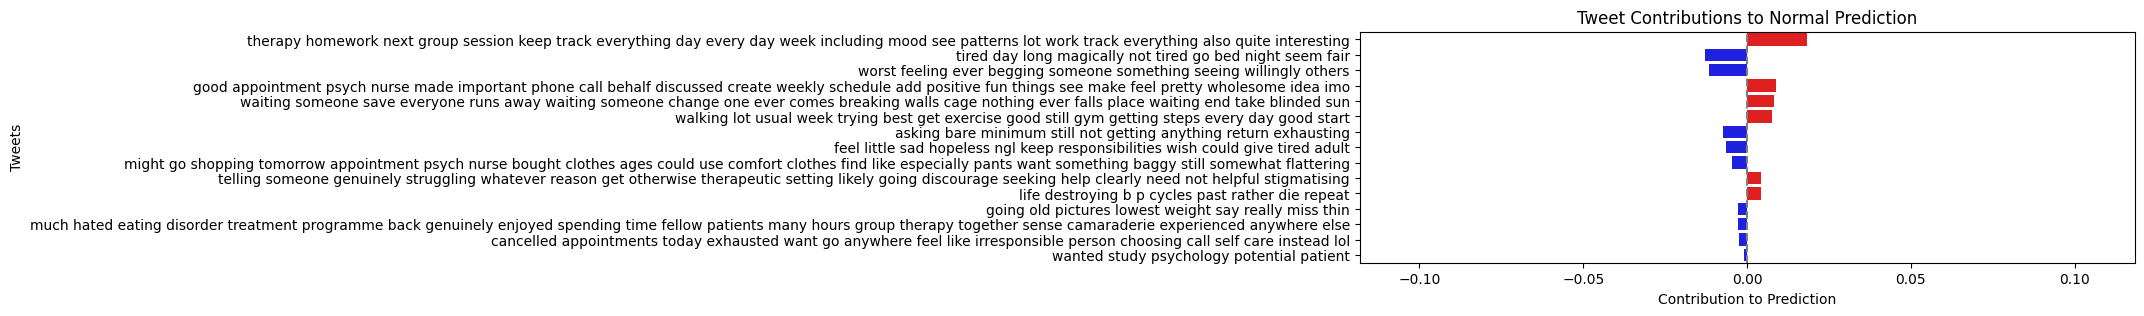



User  Tweets: ['strong thanks literally choice', 'not mock pain endured', 'love real feel deepest sense comfort quietly sitting next', 'argue explain stopped showing goodbye closure one day everything next nothing ghosted quietly completely like never existed', 'asking forever consistency reply take days presence vanish overnight disappeared like never worth goodbye carries silence warmth used live', 'ignore forget everything', 'look pretend someone never met', 'scary people unlove like nothing', 'believe people actions make clear respect regard regardless say actions clearly indicate value notice take remember actions speak louder words', 'please get phase everything feels heavy', 'relationship constant reassurance try settle little issue worsen afraid losing', 'mood cuddled aggressively', 'love softness heart never something ashamed giving receiving kindness', 'ou end really disappointed think people not everyone heart', 'close eyes things not want see cannot close heart things not

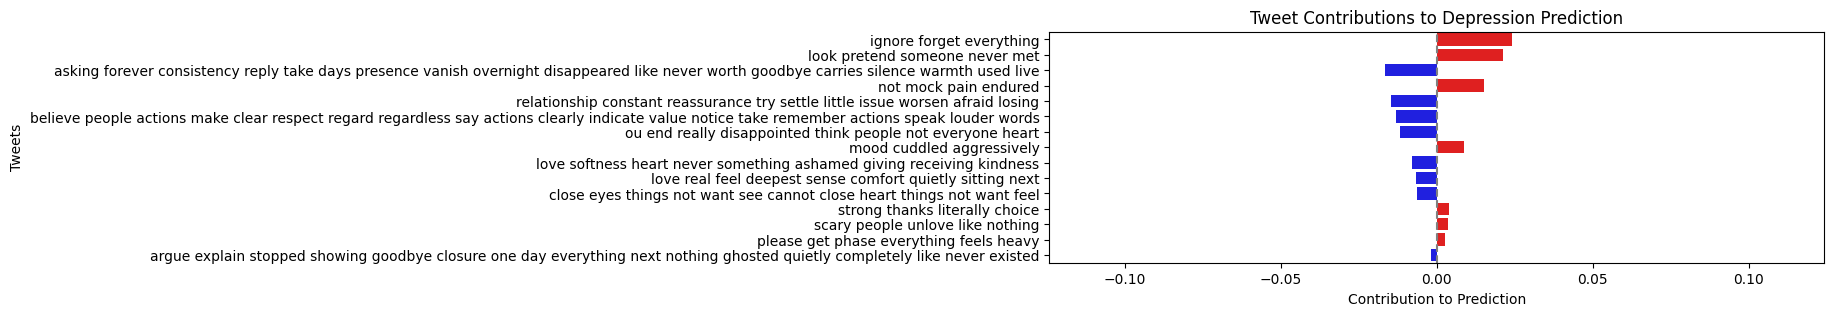



User  Tweets: ['handled well went insane lost spark distanced everyone hated', 'best decision ever made quiet nothing prove not fixing break not fighting anyone see worth whatever moving forward free peace', 'never go back place made feel ignored excluded', 'communication never hard someone actually wants', 'lord please calm mind heal heart remove worries', 'silent days wish could tell younger self far come much go', 'inconsistency unattractive hell gonna treat someone like mean something u one day act like dont exist next', 'realized never anyone priority favorite', 'good get loved gets used', 'wanted consider l would wanted reassure would wanted questioning ever let things air not line everything working towards let go', 'nobody understands hard forget one traumatic experience keeps bothering mind', 'nothing hurts trying best still not good enough', 'accepted treatment deserve always say understand wonder even consider feelings make changes sadly hope consistent ends disappointment

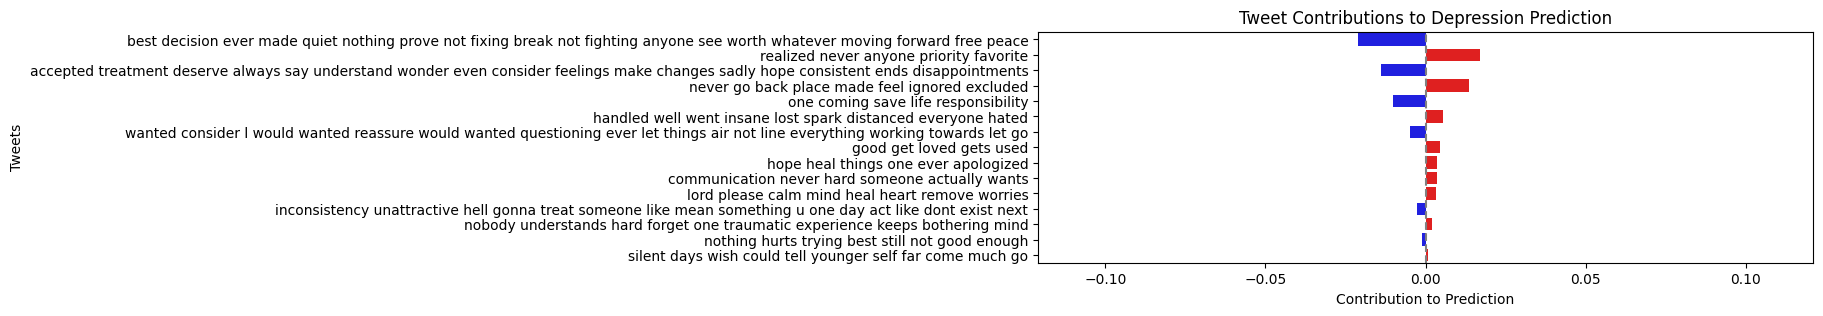



User  Tweets: ['rather not care bout pretend', 'choose detachment instead wondering treat way deserve', 'focus done enough everyone else', 'accept situation move', 'everyone going hurt need find one worth hurting', 'best feeling happiness happy made somebody else happy', 'reading sign something nice today', 'okay give second chances really care okay give chances not mistake', 'people waiting see fail people waiting see quit make wait forever', 'time come tears fall not problems god answered prayers', 'focus done enough everyone else', 'real pain know react anymore stare question lot things', 'good person left traumatized excuse act distant sometimes', 'time come tears fall not problems god answered prayers', 'inconsistent unavailable', 'honesty expensive gift expect cheap people']
Predicted class: Depression


<ipython-input-130-92ea86c808ad>:28: UserWarning: The palette list has more values (16) than needed (14), which may not be intended.
  sns.barplot(x=contributions, y=tweets, palette=colors)


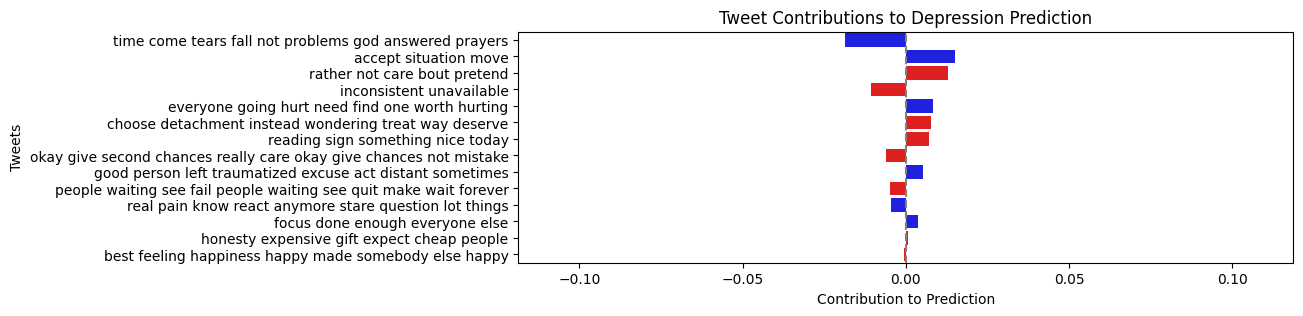



User  Tweets: ['sabotage relationships think better leave everyone leaves eventually', 'bpd makes pushover ill go way make others happy desperate attempt prevent leaving im easily manipulated bc im aware happening let bc mind stand itll push ppl away shit existence live', 'bpd got vibing demons', 'bpd stands still love', 'emotional roller coaster fire want stop feeling every twist turn bpd im numb like tv static want beat tv bat feel something bpd right', 'life would go without', 'lowkey want someone run truck feel something', 'somebody gonna match freak call best pussy disorder nothing', 'bpd rd degree burns bpd buried alive forced breathe maggot filled dirt bpd drowning watching ppl purposefully withhold lifebouy bpd considered automatically untrustworthy bpd fighting life considered monster', 'filled much unexplainable uncontrollable anger seeing red idk stop extremely reactive idk bpd rage isolate push ppl away one deserves receiving end emotion struggle contain', 'ppl bpd get ov

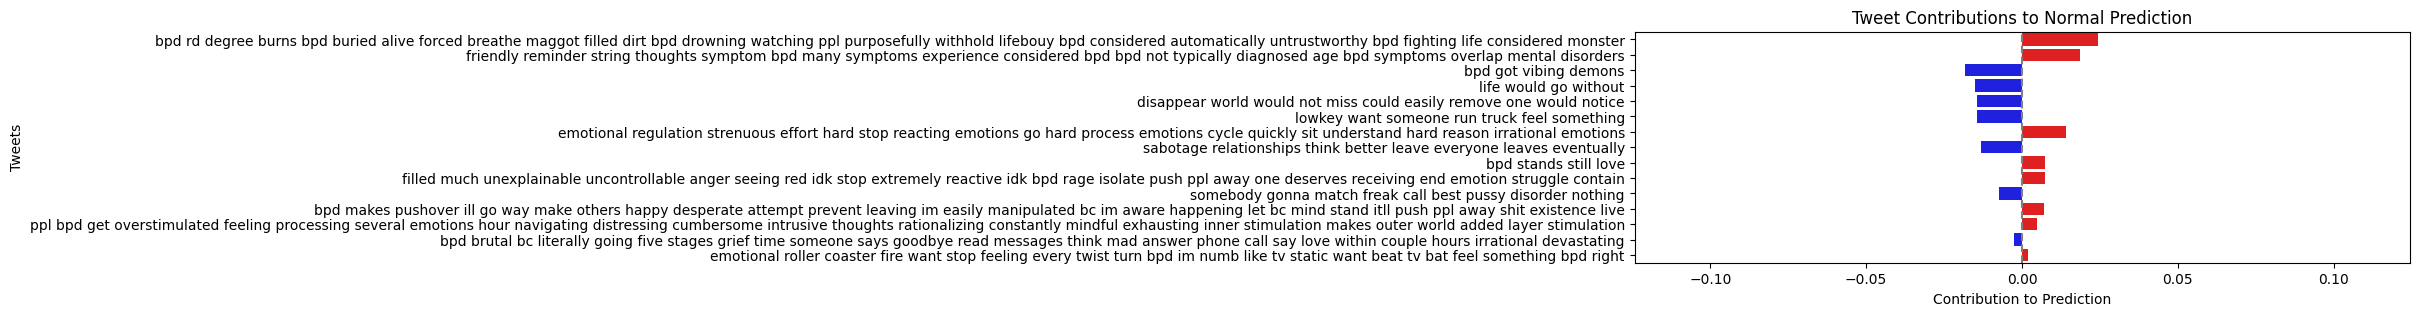



User  Tweets: ['whenever feel really tense scream onizukiiiii voice dude makes relax instantly', 'great teacher onizuka problematic still one favorites animes rewatch onizuka goofy silly guy like watch dumb', 'songs ever written song love heart sing often brings back feelings wrote', 'oh birthday around corner may th believe already year pretty depressed', '', 'get midi keyboard see massive improvement instrumentals especially bass since id able use vsts instead guitar', 'thought cuddle boobs get way started laughing like psycho', 'embarrassed never stopped belting loud house', 'could much', 'not depressionposting quadonka reference', 'surprised one said wanna ghost song going basically know think everyone hates true hate hate', 'love friends call bullshit even grumpy moment know real friends', 'lost thinking', 'think pretty think small unintentional pretty depressed reference', 'however terrible always read cross dressing manga feel obligation read every one come across']
Predicted 

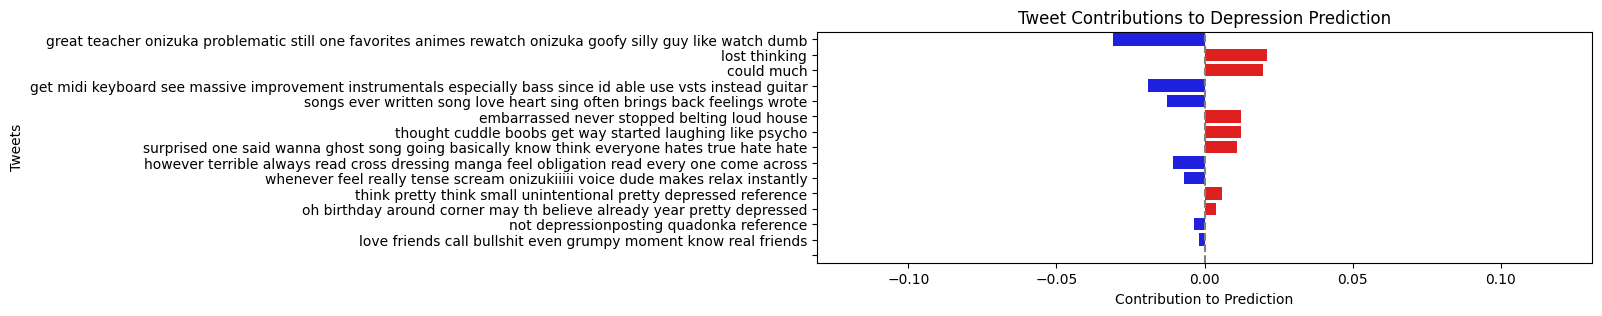



User  Tweets: ['real pain know react anymore stare question lot things', 'meeting worst thing life sorry', 'hate random sad days heavy heart anxious mind worst', 'damaged fuck never hurt anyone way hurt', 'one noticed hurt actions drained everyone noticed anger distance', 'mental breakdown alone without anyone knowing hard hiding behind smiles pretending alright silent battles never talk speak praying win life', 'life testing hard lately mean survive damn give break', 'worst feeling find mean much someone thought look stupid caring much', 'think people understand stressful explain going head even understand', 'stop letting people consume call go sleep message put phone better day left read delete conversation make effort match energy never let happiness depend anyone', 'begged someone love way loved saddest thing ever done', 'got betrayed gaslighted disrespected heart intentions genuine pure never forget', 'dear self sorry always putting situation know want loved treated way treat ot

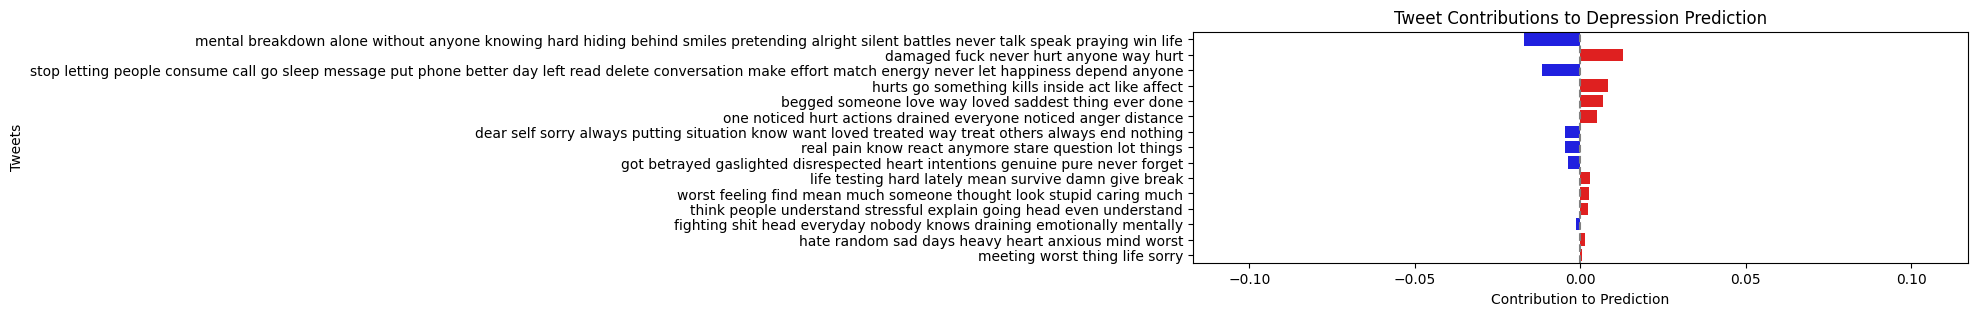



User  Tweets: ['know talk sex workers like normal problem say like bacon breakfast someone comments asking bend spread put bacon strip ass not normal behavior bro', 'guys believe life death', 'believe nothing raised church grandpa pastor idk logically believe anything death use believe reincarnation think cool idea ultimately doubt thats actual thing', 'actually nvm first loves name arm shit curse actually lol', 'ur not wrong things would easier dead lol', 'someone please get sewing machine sign class', 'really want create time hobbies want join sewing pottery class book club want learn draw take art class community college connect w nature overall reduce screen time', 'depressed even consciously know things going well life im conditioned thinking feeling like everything falling apart truly happy live moment want work cause def not fair', 'like generally unhappy person lol not positive comes friend stranger always happy wishing well treat way treat others idk', 'love new home sat bed

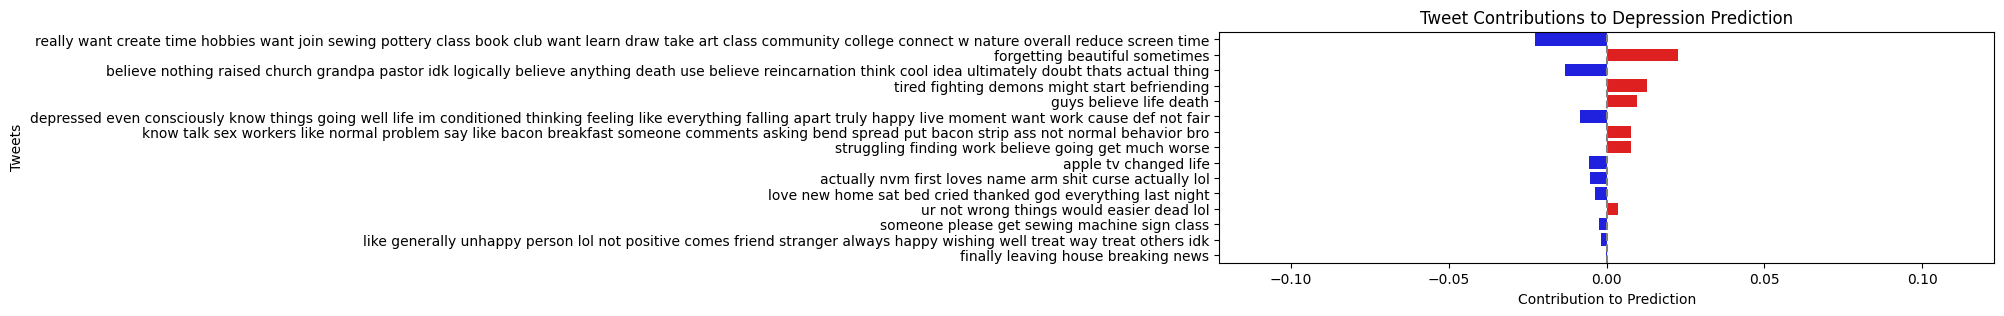



User  Tweets: ['horniness period fvckn sick unreal', 'lady never find bewitching another woman man', 'dumping struggles academically also valid reason', 'clinging someone love back way need among excruciating heartaches heal', 'baby deserves happy mom take care sis', 'men face unique challenges unemployment family attitudes shift respect diminishes input ignored kindness conditional contribution may universe compassionate brothers work', 'seeing others enjoy fruits labor not invitation ask anything allow bask rewards earned effort', 'allow friends influence feel partner reflects poorly character', 'avoid becoming baby mama costs not put position tied loser forever', 'hold dearest often ones harbor deepest disdain', 'biggest hater always man love lost', 'father everything child not favor mother responsibility', 'friendship ends real life need stay connected social media continue following show hard feelings lingering affection', 'known gotlo bora nkabe kele pregnant', 'even na next ye

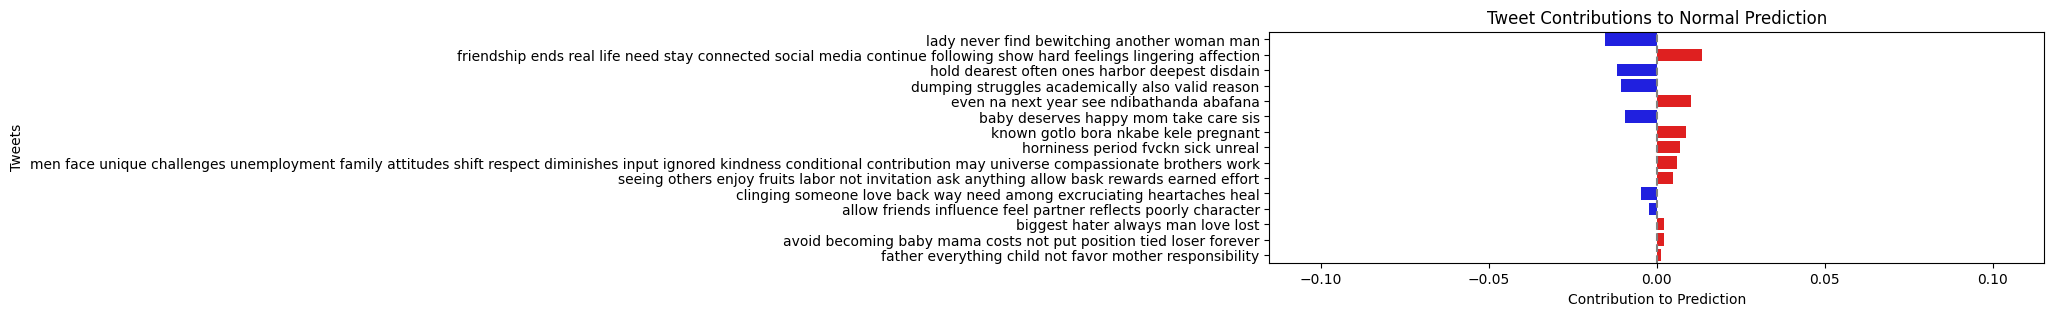



User  Tweets: ['please anybody followers people genuinely enjoyed page watch grow conversated please give minute explain situation read', 'unable get daughter anything christmas want end home homeless half years car accident august ever since struggling anything helps even dollar thank', 'feel like failure', 'life beating ass', 'love love funny works huh', 'wish lot shit wish', 'breaking point havent ate proper meal meal general days account negatives month due trying responsible pay bills fuck much please check friends family lowest', 'felt minute trying positive hard soul hurts', 'struggling mentally financially emotionally months lost management position love life car soon maybe house life good tried talk reach help nothing nobody seems care', 'november always worst month', 'wonder fuck die', 'back active sorry long break', 'miss guys also miss happy drugs not heal pain anymore', 'life fucked grateful alive fuck want pain end', 'lot changed life sorry active mental health best']
P

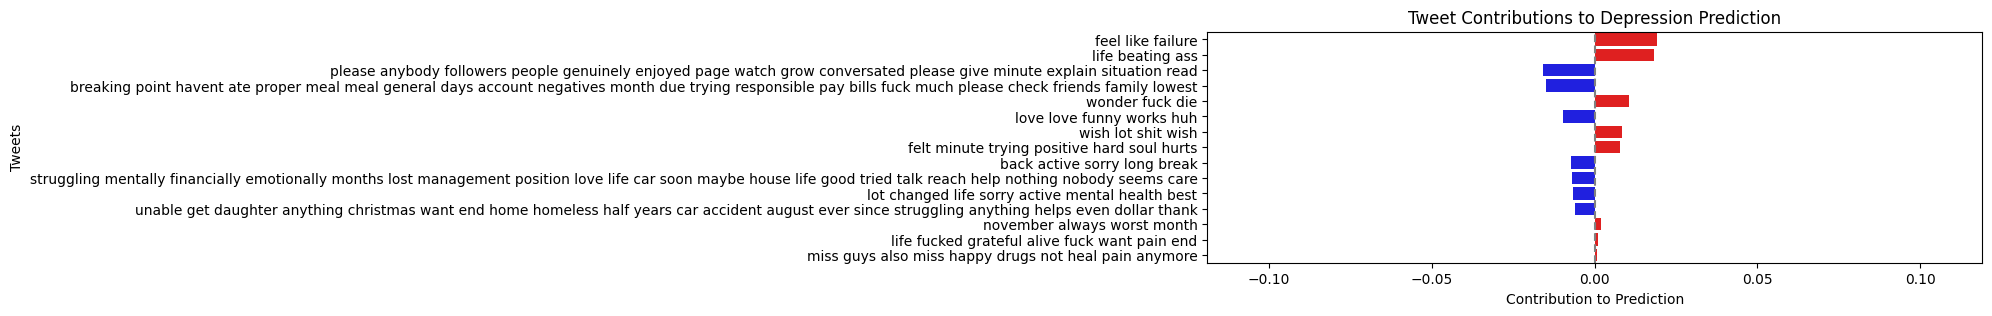



User  Tweets: ['academic anxiety cause demise', 'everyone around stable happy relationships', 'hate friends', 'mood bad noone make talk today', 'busiest day tomorrow sleep', 'done', 'entire hour waiting end fucking misery already', 'madrid stressing sm already anxious', 'tired rn', 'resisting urge cry soon someone gets little mean', 'friends think depressed clearly', 'feeling mentally ill today', 'even sleep man', 'losing mind honestly', 'not recover btw']
Predicted class: Depression


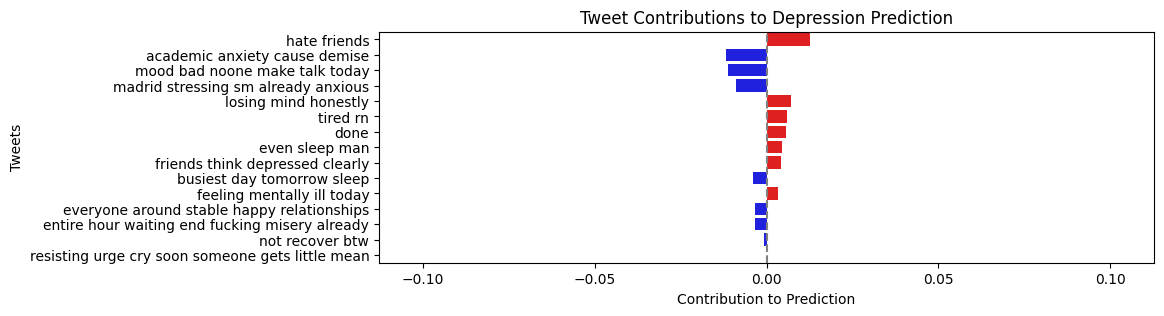



User  Tweets: ['every single time take one character personality tests get jonathan byers stranger things', 'chopped not even funny genuinely repulsive bro', 'miss things simple', 'depressed eat get bed brush teeth ounce pounds homework lord help think pills counter world would look like without thought suicide like comfort', 'hate brother', 'nights make feel loneliness intensely ltruly anyone talk', 'mad world wish one living', 'post written like one dork diaries entries trying figure explain situation easily possible without confusion', 'think go walk park maybe', 'wtf', 'everybody family hates okay hate', 'best friend left read hour scared literally never left read', 'eyes soulless always look droopy sad', 'school ages cause insanely depressed everyone school hates feel like wasted potential', 'know nothing except self sabotage']
Predicted class: Depression


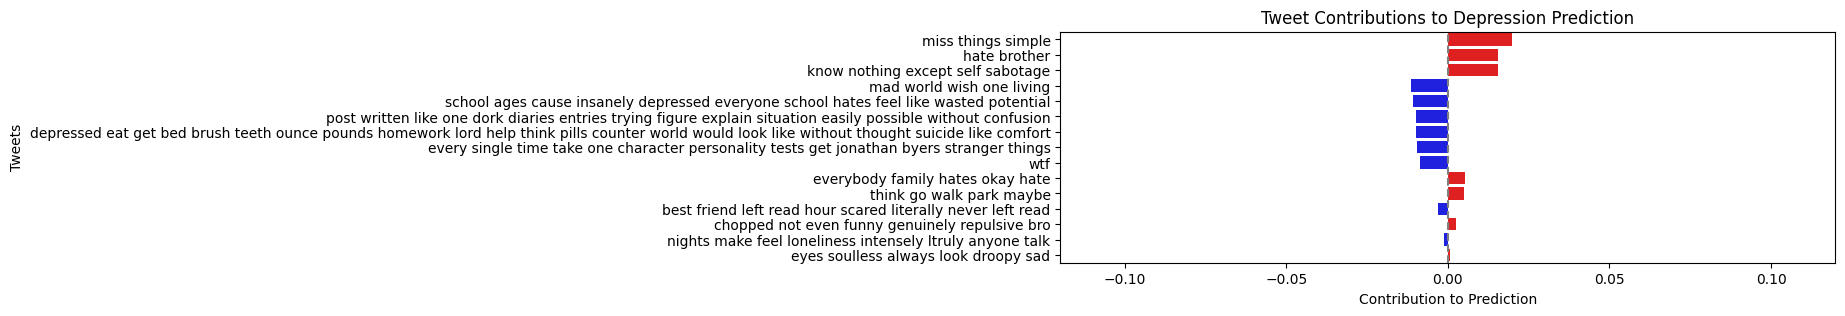



User  Tweets: ['never mind depression notice', 'god got good seats gonna prolly go stand eventually though', 'feel depressed even took little vacation god please relieve exhausted', 'not experiencing life life experiencing', 'world mine take enemies front god', 'ears ring loudly silence care medical term already know fucking annoying trying meditate lesson push thru whatever tho', 'wish word weird almost anxious aimless stasis get hectic shift service industry takes much regulate sometimes', 'literally started crying yesterday middle ocean saw new episode one piece available stream crunchyroll', 'good morning everyone survived month timeskip', 'hey world big beautiful thankful able see', 'cozy colorful like life', 'going outside working physical well reading real books imperative', 'ever since child ever wanted stare night sky always called mom would make come inside still get feeling today stare long enough start tell things', 'systemically not agree w death penalty not system prefe

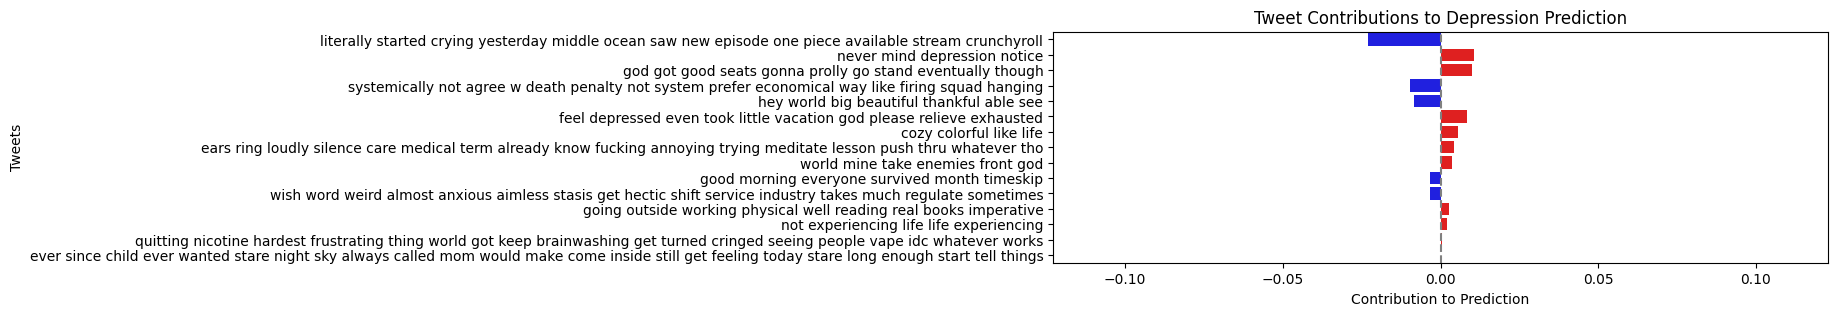



User  Tweets: ['anxious sleep hope', 'not sure eating habits weight feel like gained much scared even step scale anymore appetite still not eating best things making depressed motivation though', 'people think depression means sad crying time depression stuck twilight zone think respond things nothing interesting feel empty not sad blank lot days like hard', 'got fancy new dining table today going delivered morning post pictures excited beautiful feeling like real adult lol', 'build home inside always place go', 'good morning say p finally got sleep apple cinnamon oatmeal toast lemon verbena jam good', 'true joy struggle improve artist', 'feel like socializing talking day since therapy oof heavy overstimulating not bad way either still lot exhausted need wind feel like fine mush', 'friend evening extremely nice messaged therapy feeling therapy heavy trauma processing feeling decided go get food go look bookstores', 'well really deep therapy session feel kind nauseous need something u

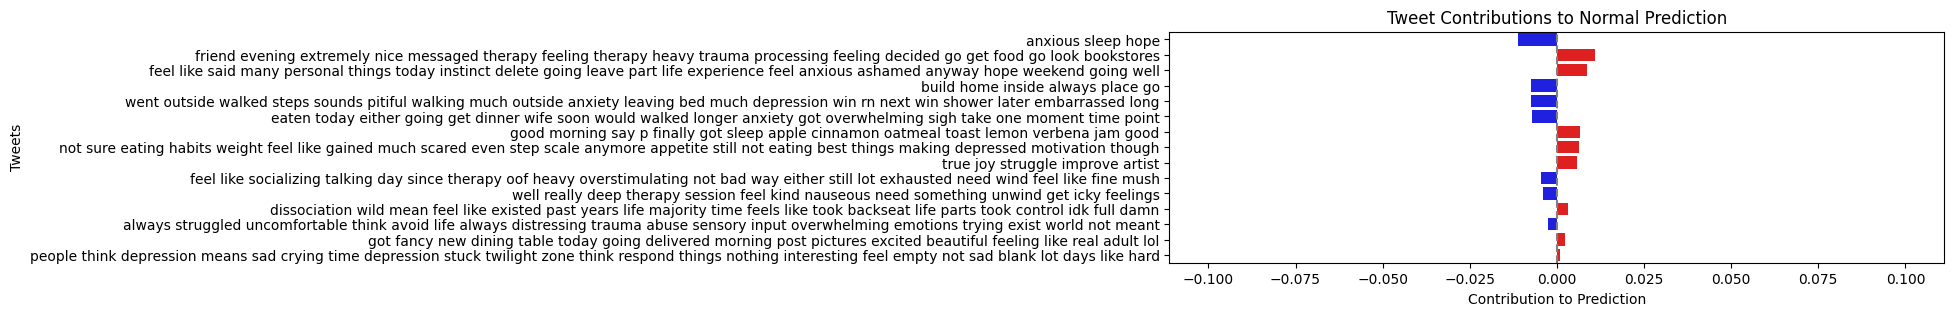



User  Tweets: ['get home ill try allergy meds see help allergies driving crazy possible head hurts bad lately', 'wits end fixing headache trying avoid tylenol long possible cup coffee ate yogurt almonds took iron supplement cus maybe anemia hurting might take b', 'hung upside bed seconds get blood rushing head hopes would help', 'miserable much pain', 'headache', 'feel insane want dead', 'really depressed still sorta depressed also filled energy super restless stuff last time happened got high dyed hair someone apartment pierced ears sewing needle', 'also particular reason started working like ton like constantly busy stuff crashed burned bad went mental hospital guess avoid mental hospital time', 'day planned restless get things done', 'feel mental breakdown coming', 'depressed restless', 'want go sleep never wake', 'want pretty want people love', 'get extremely depressed write lot found', 'wanna sh wanna cover scars hurt goes away want disappear']
Predicted class: Depression


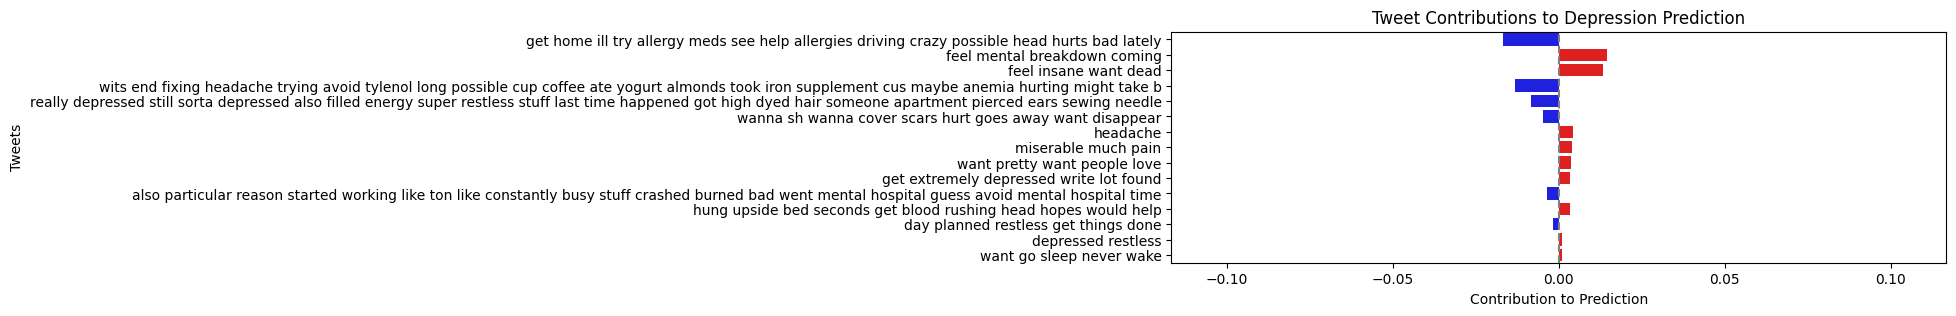



User  Tweets: ['depression fact entire existence nothing failure failure personally financially professionally living exactly zero expectations real bitch half', 'really annoying go multiple stores basic first aid medical supplies ones need stolen people need safely inject fucking poison bodies get fucked ya bums', 'used dreams desires wants joy hobbies taken away gone end sight living exist barely failed every aspect life old life ages ago pain misery dragging along', 'need move significantly less populated place', 'getting real fucking sick hospitals time', 'slowly breaking letting go soon', 'let leave old lives behind belong run away together take deaths move inland buy land build empire together maybe llamas', 'rides much finish ride took good bad straight thru indifference without second look', 'order pizza kill', 'shit fun anymore', 'really trying set someone go trying take away dream dying alone mountain cabin bullet head', 'thinking lot dying lately honestly wait', 'surgery f

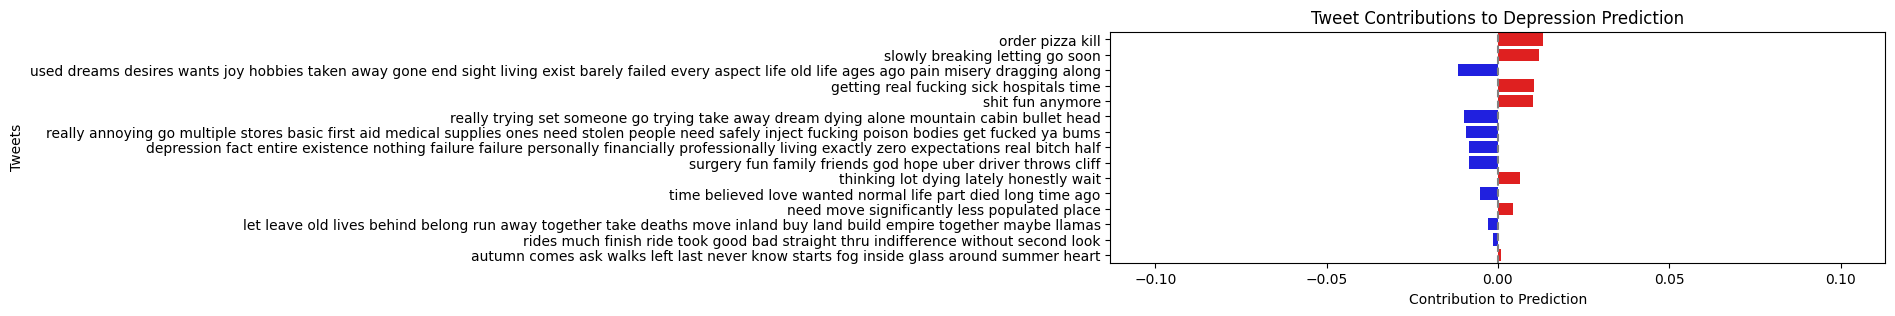



User  Tweets: ['like allow jealousy spoil friendship nah friend dey feed since last two weeks', 'always keep relationship private two', 'become cold hearted nothing ever hurt', 'every right believe whatever want', 'stop smiling remember broke single', 'world belongs hustle', 'keep chasing goals whether alone broke tired keep going', 'old man told start think de th end', 'nice not fool', 'back miss', 'create time enjoyment brother time pain creates', 'active', 'someone help struggling not help love', 'shall go peace come back home peace', 'matter lonely feel life never tolerate invite toxic people life drain']
Predicted class: Depression


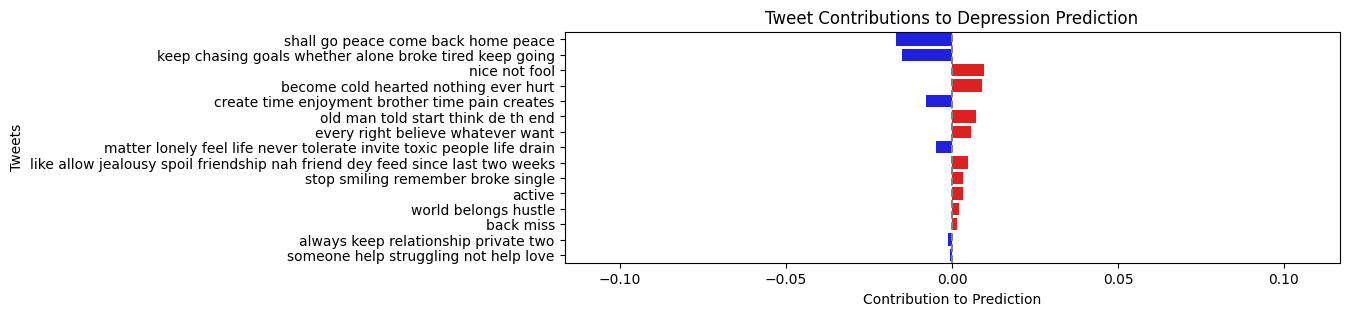



User  Tweets: ['oh god someone please tell okay want die mean overdose', 'okay ill okay', 'okay okay need tell okay', 'cook oh goddd', 'going kill', 'fikcing overdosing everyday doed nothing want kill badly hsve nothing left live absolutely nothing stop', 'need help desperately', 'ik going kill', 'took rest scared tomorrow anything keep alive', 'live like anymore', 'feel horrible going take', 'know much longer genuinely considering legitimately', 'not ok tell friends csnt anymore', 'fucking tired', 'actually killing one cares one wants help']
Predicted class: Depression


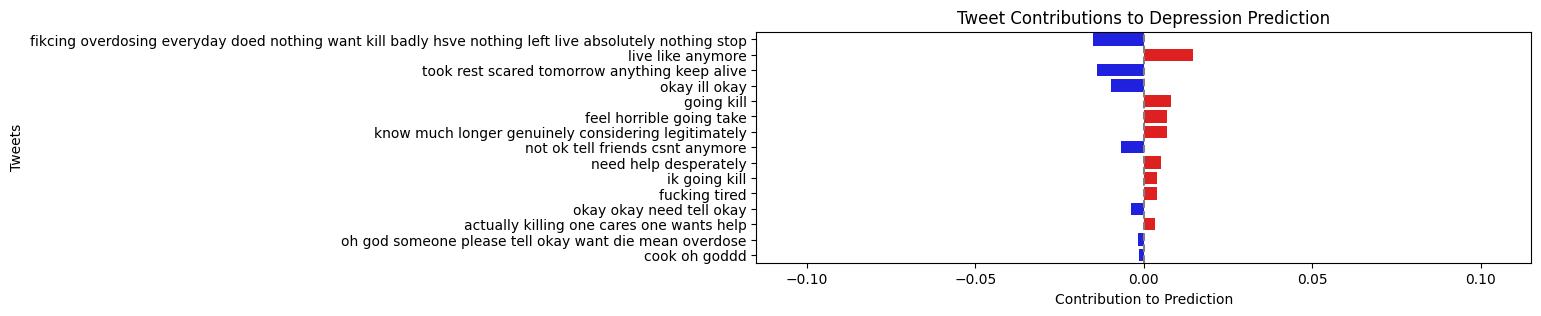

In [ ]:

# Assuming label_encoder and other necessary functions are defined
explainer = LimeTextExplainer(class_names=label_encoder.classes_)
print("LIME Explanations (Tweet-Level Contributions):")

for user_tweets in user_data:
    predicted_class = detect_depression_user(user_tweets)
    print(f"User  Tweets: {user_tweets}")
    print(f"Predicted class: {predicted_class}")
    tweet_contributions = []

    for i, tweet in enumerate(user_tweets):
        cleaned_tweet = clean_statement(tweet)
        perturbed_tweets = user_tweets[:i] + user_tweets[i+1:]
        original_probs = predict_proba_user(user_tweets)[0]
        perturbed_probs = predict_proba_user(perturbed_tweets)[0] if perturbed_tweets else np.array([0.5, 0.5])
        contribution = original_probs - perturbed_probs
        tweet_contributions.append((tweet, contribution[label_encoder.transform([predicted_class])[0]]))

    tweet_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Prepare data for plotting
    tweets, contributions = zip(*tweet_contributions)
    contributions = np.array(contributions)

    # Create a bar plot
    plt.figure(figsize=(10, 3))
    colors = ['red' if contrib > 0 else 'blue' for contrib in contributions]  # Highlight positive contributions in red and neg with blue
    sns.barplot(x=contributions, y=tweets, palette=colors)

    plt.axvline(0, color='grey', linestyle='--')
    plt.title(f'Tweet Contributions to {predicted_class} Prediction')
    plt.xlabel('Contribution to Prediction')
    plt.ylabel('Tweets')
    plt.xlim(-max(abs(contributions)) - 0.1, max(abs(contributions)) + 0.1)
    plt.show()

    print("\n")